# Deep Learning Project 1 - MLPs and CNN for image classification
> **MSc in Data Science, AUEB**<br />
> Giogiakas Sotirios ( *p3352204* ) <br />
> Sakkis Panagiotis ( *p3352222* ) 

## Fashion MNIST Dataset

Imports

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import random
import matplotlib.pyplot as plt

import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from keras.models import Model
from keras.models import load_model

print(tf.__version__)

/Users/panagiotissakkis/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


2.15.0


In [2]:
random_seed = 42
random.seed(random_seed)
tf.random.set_seed(random_seed)
np.random.seed(random_seed)

Helper Functions

In [3]:
def plot_image(i, predictions, true_labels, img, class_names):
    predictions_array, true_label, img = predictions[i], true_labels[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    predicted_label = np.argmax(predictions_array)
    
    if predicted_label == true_label:
        color = 'green'
    else:
        color = 'red'
  
    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                         100*np.max(predictions_array),
                                         class_names[true_label]),
                                         color=color)

In [4]:
def plot_value_array(i, predictions, true_labels, class_names, show_xticks=False):
    predictions_array, true_label = predictions[i], true_labels[i]
    plt.grid(False)
    plt.xticks([])
    if show_xticks:
        plt.xticks(range(10), class_names, rotation='vertical')
    else:
        plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)
 
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('green')

### Load Dataset

In [5]:
fashion_mnist = tf.keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Preprocess the data

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. The labels are an array of integers, ranging from 0 to 9. These correspond to the class of clothing the image represents:

In [6]:
train_images.shape

(60000, 28, 28)

In [7]:
test_images.shape

(10000, 28, 28)

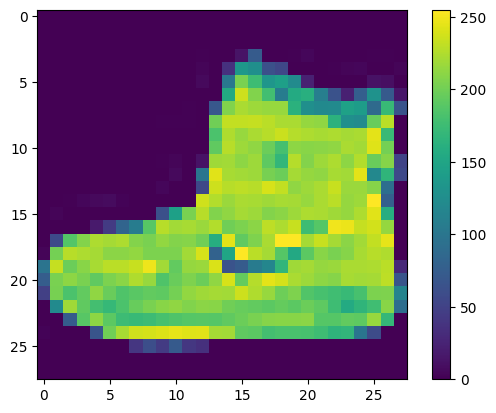

In [8]:
plt.figure()
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

Normalize image values in range [0,1]

In [9]:
train_images = train_images / 255.0

test_images = test_images / 255.0

Display first 25 images from training set.

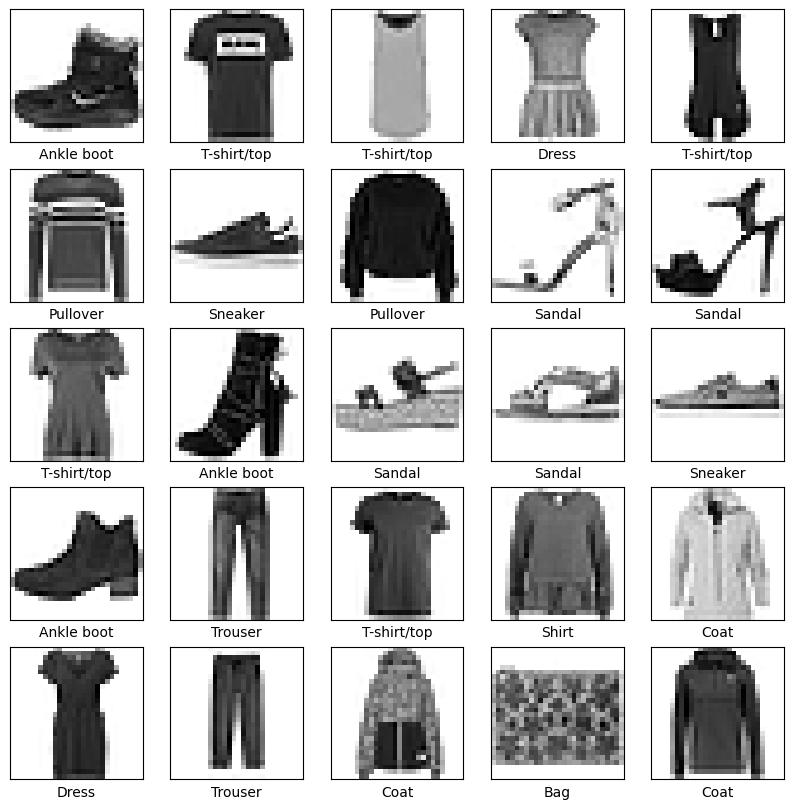

In [10]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
    
plt.show()

Plot Class Distribution

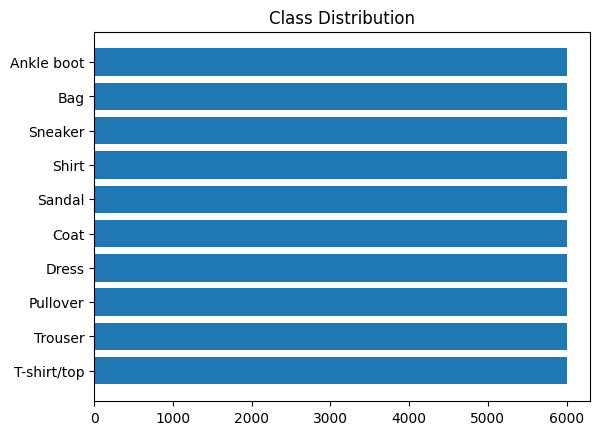

In [11]:
counts = np.bincount(train_labels)

uniques = np.unique(train_labels)

plt.barh(uniques, counts, align='center')
plt.yticks(uniques, class_names)
plt.title('Class Distribution')
plt.show()

### MLP Model

In [12]:
def build_model(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(28, 28)))


    layer_index = 0 
    for i in range(hp.Int(name='num_layers',min_value=1,max_value=2)):
        if layer_index == 0:
            model.add(tf.keras.layers.Dense(hp.Int('units', min_value=32, max_value=512, step=32),
                            activation='relu')
                    )
            model.add(tf.keras.layers.Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2])))
        else:
            model.add(tf.keras.layers.Dense(hp.Int(name='hidden_units_'+str(i),min_value=128,max_value=512,step=64),
                            activation='relu'))
            model.add(tf.keras.layers.Dropout(hp.Choice(name='dropout_layer_'+str(i),values=[0.1,0.2])))
        
        layer_index += 1

    # Add last layer that produces the logits
    model.add(tf.keras.layers.Dense(len(class_names),  activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.001, 0.0001, or 0.00001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 1e-5])

    # Select optimizer    
    optimizer=hp.Choice('optimizer', values=['adam','SGD'])

    # Conditional for each optimizer
    if optimizer == 'adam':
        opt = tf.keras.optimizers.legacy.Adam(learning_rate=hp_learning_rate)
    elif optimizer == 'SGD':
        opt = tf.keras.optimizers.legacy.SGD(learning_rate=hp_learning_rate)

    # Now compile your model with previous param
    model.compile(
        optimizer=opt,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy']
    ) 

    return model

In [13]:
tuner = kt.Hyperband(build_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     overwrite=True,
                     seed=42,
                     project_name='deep_lr_1')

2024-03-16 19:20:36.370044: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-03-16 19:20:36.370063: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-03-16 19:20:36.370069: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-03-16 19:20:36.370094: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-16 19:20:36.370106: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

In [15]:
tuner.search(train_images, train_labels, epochs=50, validation_split=0.2, callbacks=[early_stopping])

Trial 30 Complete [00h 01m 06s]
val_accuracy: 0.7754999995231628

Best val_accuracy So Far: 0.8382499814033508
Total elapsed time: 00h 14m 10s


In [16]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'num_layers': 1,
 'units': 480,
 'dropout_layer_0': 0.1,
 'learning_rate': 0.0001,
 'optimizer': 'adam',
 'hidden_units_1': 128,
 'dropout_layer_1': 0.1,
 'tuner/epochs': 10,
 'tuner/initial_epoch': 4,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0013'}

In [17]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 480)               376800    
                                                                 
 dropout_1 (Dropout)         (None, 480)               0         
                                                                 
 dense_3 (Dense)             (None, 10)                4810      
                                                                 
Total params: 381610 (1.46 MB)
Trainable params: 381610 (1.46 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
history = model.fit(train_images, 
                    train_labels, 
                    epochs=50, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

Epoch 1/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.6735 - accuracy: 0.7737 - val_loss: 0.5075 - val_accuracy: 0.8295
Epoch 2/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4888 - accuracy: 0.8345 - val_loss: 0.4632 - val_accuracy: 0.8393
Epoch 3/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4576 - accuracy: 0.8432 - val_loss: 0.4456 - val_accuracy: 0.8461
Epoch 4/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4449 - accuracy: 0.8468 - val_loss: 0.4359 - val_accuracy: 0.8508
Epoch 5/50
1500/1500 [==============================] - 7s 4ms/step - loss: 0.4331 - accuracy: 0.8510 - val_loss: 0.4335 - val_accuracy: 0.8502
Epoch 6/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4274 - accuracy: 0.8529 - val_loss: 0.4319 - val_accuracy: 0.8506
Epoch 7/50
1500/1500 [==============================] - 7s 5ms/step - loss: 0.4339 - accuracy: 0.8510 - val_loss: 0.4323 - val_accuracy:

In [19]:
model.save("models/mnist_mlp_best_model.h5")

/Users/panagiotissakkis/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


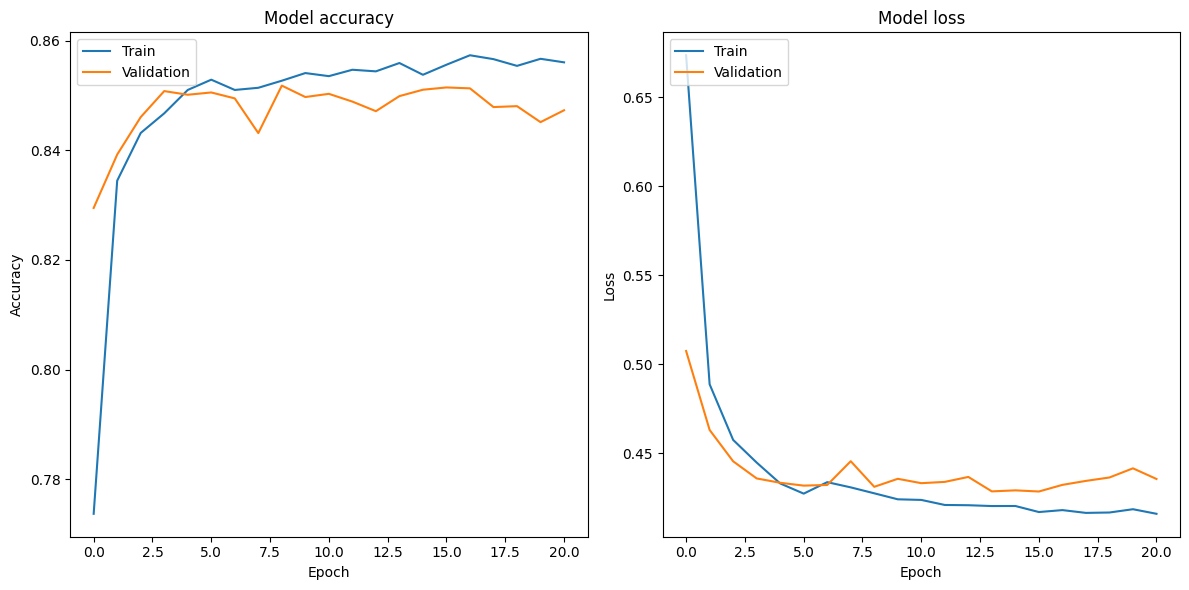

In [20]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [21]:
eval_result = model.evaluate(test_images, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 3ms/step - loss: 0.4655 - accuracy: 0.8375
[test loss, test accuracy]: [0.46548837423324585, 0.8374999761581421]


In [22]:
predictions = np.argmax(model.predict(test_images), -1)
print(classification_report(test_labels, predictions, target_names=class_names))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.79      0.80      1000
     Trouser       0.98      0.95      0.96      1000
    Pullover       0.71      0.74      0.72      1000
       Dress       0.82      0.88      0.85      1000
        Coat       0.74      0.71      0.72      1000
      Sandal       0.92      0.93      0.92      1000
       Shirt       0.58      0.61      0.60      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.97      0.92      0.94      1000
  Ankle boot       0.95      0.92      0.94      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000



313/313 [==============================] - 0s 1ms/step


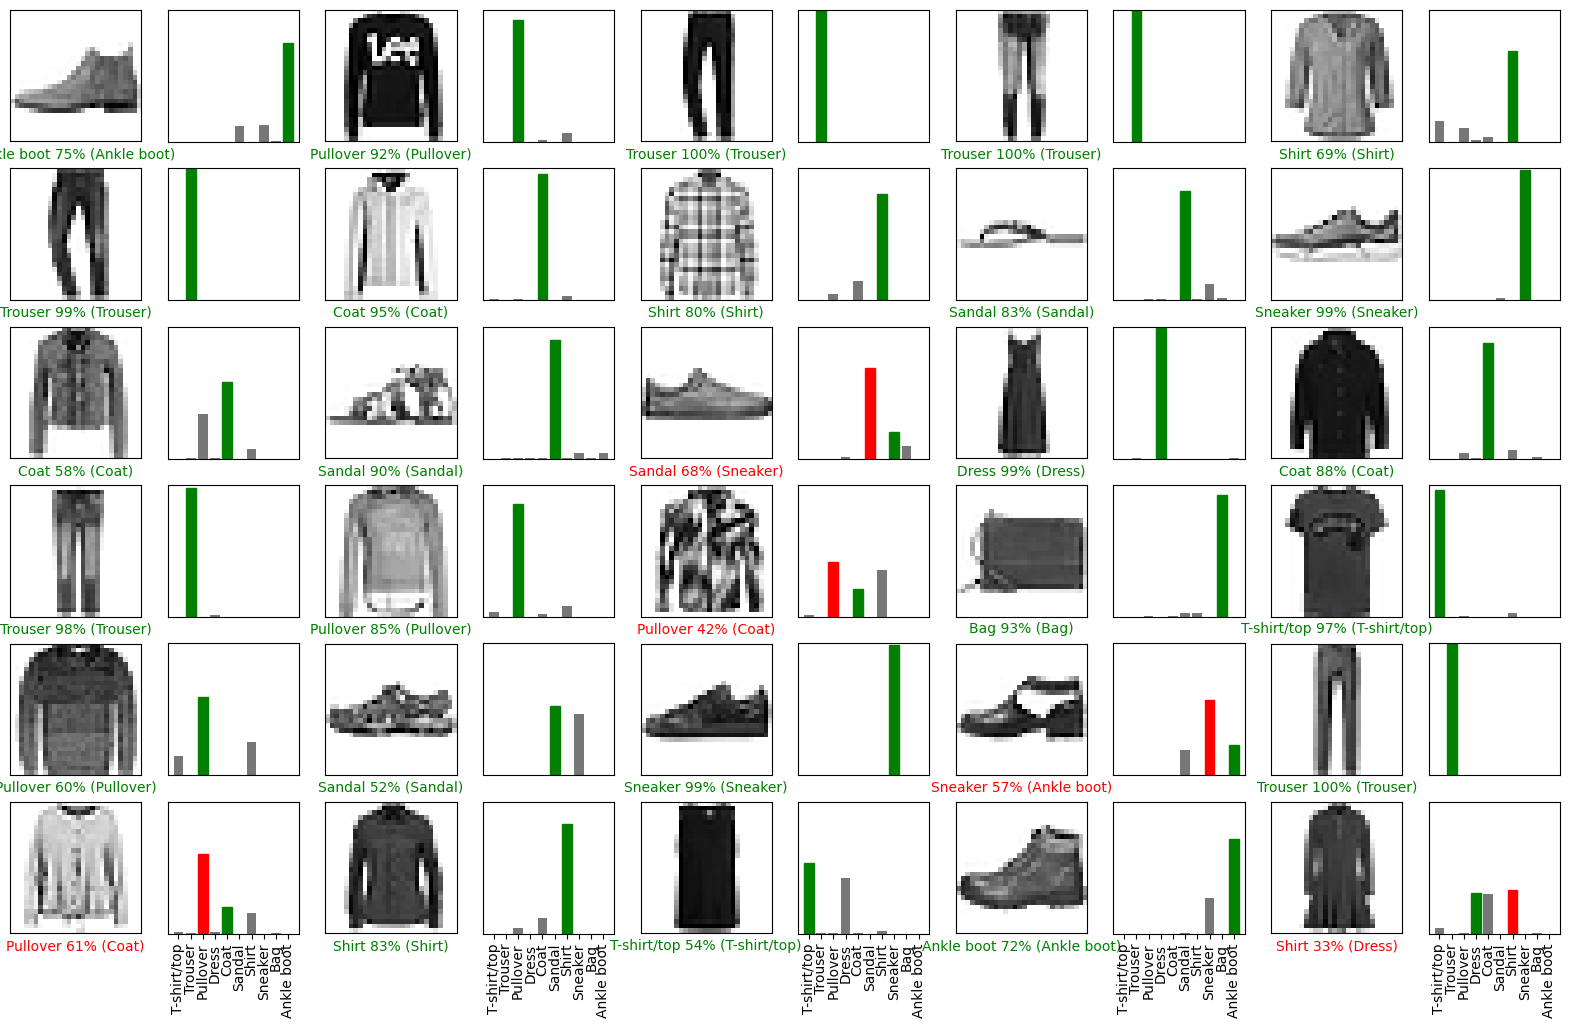

In [23]:
# verification of several images
num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

predictions = model.predict(test_images)
show_x_ticks = False

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    
    plot_image(i, predictions, test_labels, test_images, class_names)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels, class_names, show_x_ticks)

plt.show()

### CNN

In [24]:
train_X = tf.reshape(train_images, [60000, 28, 28, 1])
test_X = tf.reshape(test_images, [10000, 28, 28, 1])

Build the CNN model

In [57]:
def build_cnn_model(hp):
    # create model object
    model = tf.keras.Sequential()
    
    pooling_type = hp.Choice(f'pooling_type', values = ['max','avg'])

    for i in range(hp.Int(name='conv_layers',min_value=1,max_value=2)):
        #adding convolutional layer    
        model.add(tf.keras.layers.Conv2D(
            #adding filter 
            filters=hp.Int(f'conv_{str(i)}_filter', min_value=32, max_value=128, step=32),
            # adding filter size or kernel size
            kernel_size=hp.Choice(f'conv_{str(i)}_kernel', values = [3,5]),
            strides=(1, 1),
            padding='same',
            #activation function
            activation='relu',
            input_shape=(28,28,1)
        ))
        if pooling_type == 'max':
            # add poolling layer
            model.add(tf.keras.layers.MaxPooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                padding='same',
                name=f'MaxPool2D-{i + 1}'
            ))
        elif pooling_type == 'avg':
            # add poolling layer
            model.add(tf.keras.layers.AveragePooling2D(
                pool_size=(2, 2),
                strides=(2, 2),
                padding='same',
                name=f'MaxPool2D-{i + 1}'
            ))
    
    model.add(tf.keras.layers.Dropout(
        rate=hp.Choice(name='dropout_layer_rate',values=[0.1,0.2])
    ))

    # adding flatten layer    
    model.add(tf.keras.layers.Flatten())
    # adding dense layer    
    model.add(tf.keras.layers.Dense(
        units=hp.Int('dense_units', min_value=32, max_value=512, step=32),
        activation='relu'
    ))
    # output layer    
    model.add(tf.keras.layers.Dense(10, activation='softmax'))
    #compilation of model
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(hp.Choice('learning_rate', values=[1e-3, 1e-4])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [58]:
tuner = kt.Hyperband(build_cnn_model,
                     objective='val_accuracy',
                     max_epochs=20,
                     factor=3,
                     directory='my_dir',
                     overwrite=True,
                     seed=42,
                     project_name='deep_lr_2')

In [59]:
reduce_lr_plateau = ReduceLROnPlateau(
        monitor = 'val_accuracy',
        factor = 0.1,
        patience = 2,
        min_delta = 0.0001,
        cooldown = 0,
        min_lr = 0
)

In [60]:
tuner.search(train_X, train_labels, 
             epochs=50, validation_split=0.2, 
             callbacks=[early_stopping])

Trial 30 Complete [00h 03m 54s]
val_accuracy: 0.8134166598320007

Best val_accuracy So Far: 0.8900833129882812
Total elapsed time: 00h 41m 50s


In [61]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
best_hps.values

{'pooling_type': 'max',
 'conv_layers': 1,
 'conv_0_filter': 32,
 'conv_0_kernel': 5,
 'dropout_layer_rate': 0.1,
 'dense_units': 416,
 'learning_rate': 0.0001,
 'conv_1_filter': 64,
 'conv_1_kernel': 3,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0021'}

In [62]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
cnn_model = tuner.hypermodel.build(best_hps)
#summary of best model
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        832       
                                                                 
 MaxPool2D-1 (MaxPooling2D)  (None, 14, 14, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)              0         
                                                                 
 dense_2 (Dense)             (None, 416)               2609568   
                                                                 
 dense_3 (Dense)             (None, 10)                4170      
                                                                 
Total params: 2614570 (9.97 MB)
Trainable params: 2614

In [63]:
history_cnn = cnn_model.fit(train_X, train_labels, 
                            epochs=50, validation_split=0.2, 
                            callbacks=[early_stopping])

Epoch 1/50
1500/1500 [==============================] - 11s 7ms/step - loss: 1.0273 - accuracy: 0.7109 - val_loss: 0.7685 - val_accuracy: 0.7687
Epoch 2/50
1500/1500 [==============================] - 11s 7ms/step - loss: 0.6528 - accuracy: 0.7825 - val_loss: 0.5664 - val_accuracy: 0.7980
Epoch 3/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.5390 - accuracy: 0.8152 - val_loss: 0.5204 - val_accuracy: 0.8179
Epoch 4/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.5106 - accuracy: 0.8314 - val_loss: 0.5298 - val_accuracy: 0.8293
Epoch 5/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4841 - accuracy: 0.8383 - val_loss: 0.4628 - val_accuracy: 0.8398
Epoch 6/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4516 - accuracy: 0.8471 - val_loss: 0.4576 - val_accuracy: 0.8439
Epoch 7/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.4463 - accuracy: 0.8513 - val_loss: 0.4531 - val_ac

In [64]:
cnn_model.save("models/mnist_cnn_best_model2.h5")

/Users/panagiotissakkis/Library/Python/3.9/lib/python/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


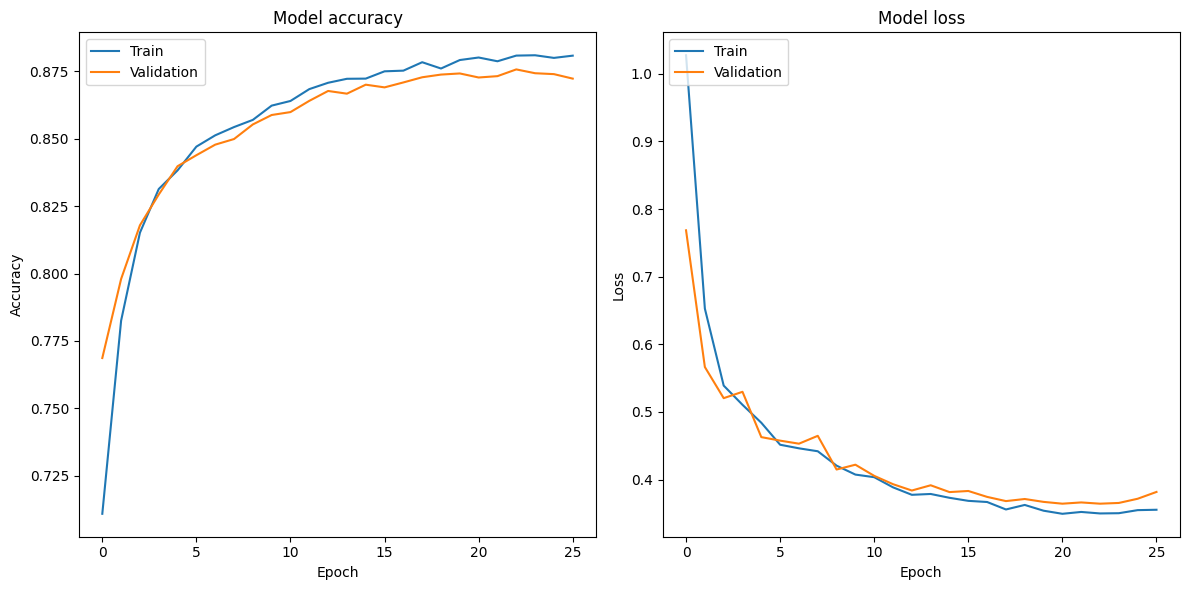

In [65]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [66]:
eval_result = cnn_model.evaluate(test_X, test_labels)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 4ms/step - loss: 0.3950 - accuracy: 0.8682
[test loss, test accuracy]: [0.39500200748443604, 0.8682000041007996]


In [67]:
predictions = np.argmax(cnn_model.predict(test_images), -1)
print(classification_report(test_labels, predictions, target_names=class_names))

313/313 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

 T-shirt/top       0.80      0.84      0.82      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.74      0.84      0.79      1000
       Dress       0.87      0.88      0.88      1000
        Coat       0.77      0.75      0.76      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.71      0.59      0.65      1000
     Sneaker       0.91      0.96      0.94      1000
         Bag       0.96      0.96      0.96      1000
  Ankle boot       0.96      0.94      0.95      1000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



313/313 [==============================] - 0s 2ms/step


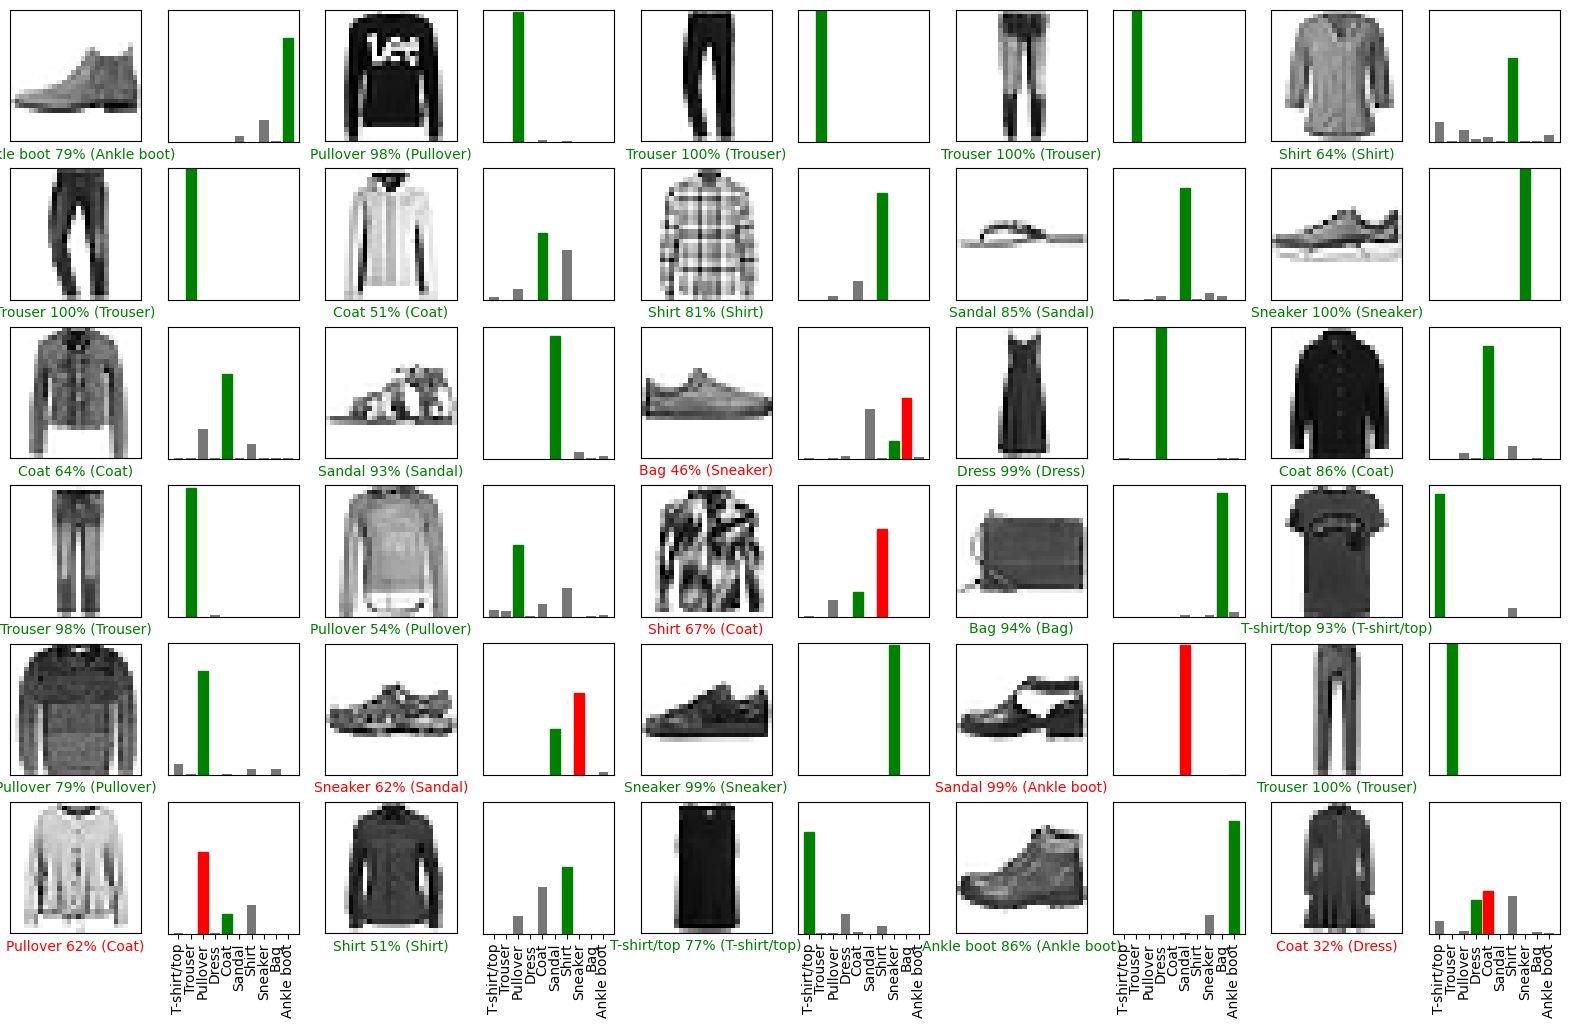

In [68]:
# verification of several images
num_rows=6
num_cols=5
num_images=num_rows*num_cols

plt.figure(figsize=(2*2*num_cols,2*num_rows))

predictions = cnn_model.predict(test_images)
show_x_ticks = False

for i in range(num_images):
    if i >= num_images - num_cols:
        show_x_ticks = True
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    
    plot_image(i, predictions, test_labels, test_images, class_names)

    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions, test_labels, class_names, show_x_ticks)

plt.show()

In [5]:
for i in range(len(cnn_model.layers)):
    layer = cnn_model.layers[i]
    if 'conv' not in layer.name:
        continue    
    print(i , layer.name , layer.output.shape)

0 conv2d_2 (None, 28, 28, 32)


In [9]:
# redefine model to output right after the first hidden layer
model_tmp = Model(inputs=cnn_model.inputs, outputs=cnn_model.layers[0].output)

In [10]:
img = np.expand_dims(test_images[0], axis=0)

1/1 [==============================] - 0s 133ms/step


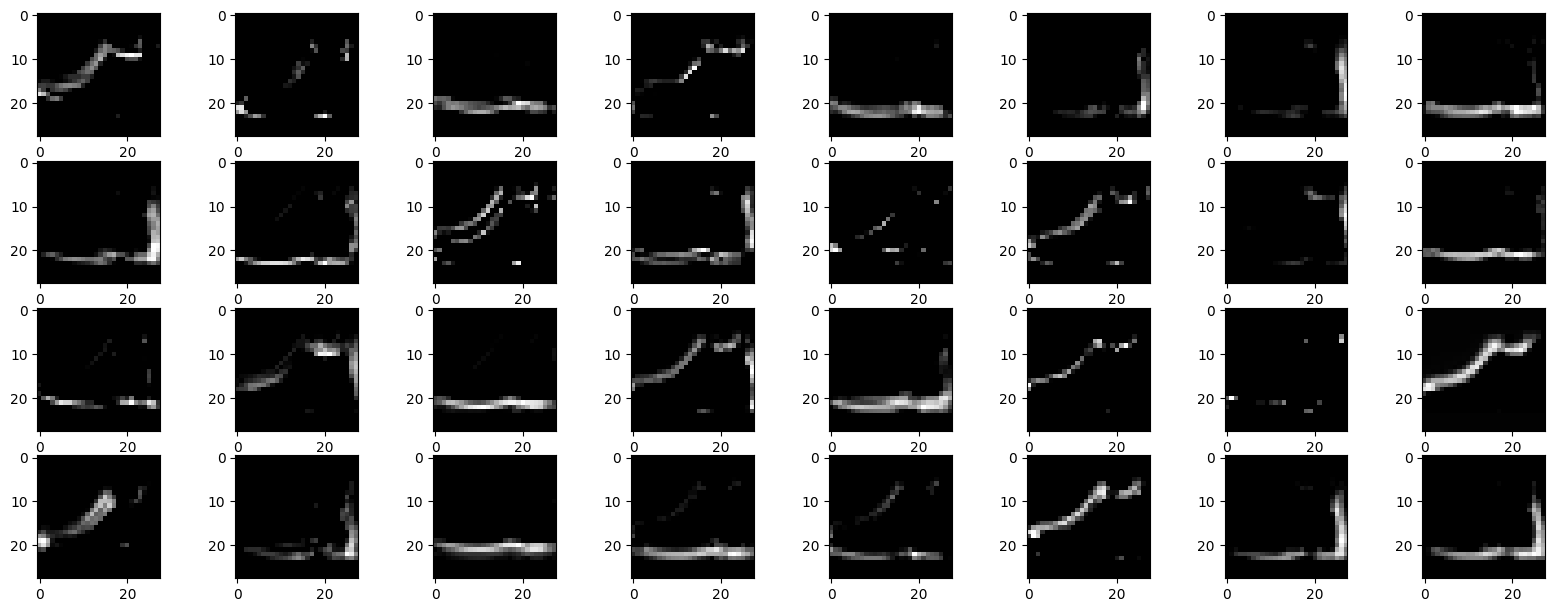

In [19]:
#calculating features_map
features = model_tmp.predict(img)

fig = plt.figure(figsize=(20,15))
for i in range(1,features.shape[3]+1):

    plt.subplot(8,8,i)
    plt.imshow(features[0,:,:,i-1] , cmap='gray')
    
plt.show()

